In [1]:
] activate .

In [2]:
using Revise
includet("isokann.jl")
includet("neurcomm.jl")
includet("sqra.jl")
Plots.gr(fmt=:png)

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/alex/.julia/packages/Revise/AIcio/src/packagedef.jl:1369
┌ Warning: Replacing docs for `Main.NN.sampletrajectories :: Tuple{Main.NN.Langevin, Any, Any}` in module `Main.NN`
└ @ Base.Docs docs/Docs.jl:240


Plots.GRBackend()

In [68]:
sigma = 0.5
@show beta = 2 /  sigma^2

process = NN.Triplewell(beta)


@show sigma = sqrt(2/process.beta)
potential = process.potential

samples = 300
branches = 10
steps = 100
dt=.01

beta = 2 / sigma ^ 2 = 8.0
sigma = sqrt(2 / process.beta) = 0.5


0.01

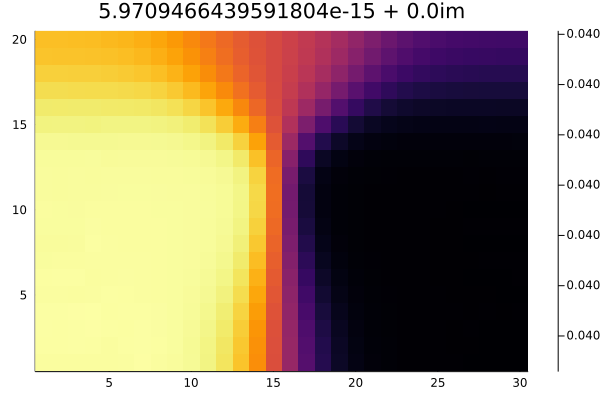

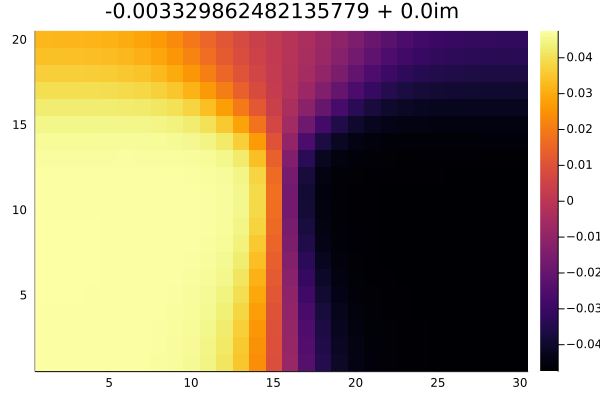

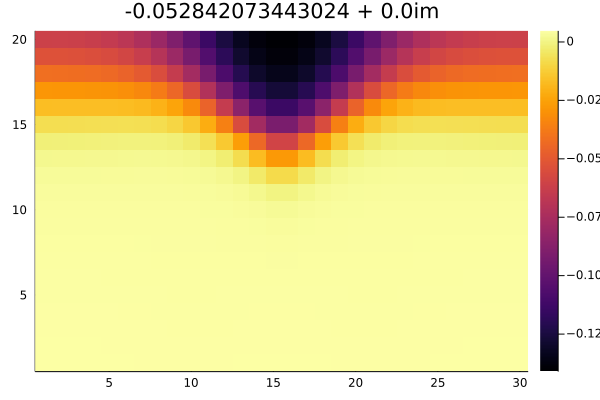

GKS: Rectangle definition is invalid in routine CELLARRAY


In [69]:
_, _, zs = NN.boxgrid(process.box, 30, 20)
Q = sqra(reshape(potential(zs), 30, 20), process.beta)

using LinearAlgebra
val, vecs = eigen(Matrix(Q))

for i=0:2
    vv = real.(reshape(vecs[:,end-i], 30, 20))
    heatmap(vv', title=val[end-i]) |> display
end

# System simulation

In [84]:
using Random
Random.seed!(1)

function eulermarujamatrajectories(x0::Matrix, potential::Function, sigma::Real, dt::Real, steps::Integer; branches::Integer=1)
    dim, samples = size(x0)
    xts = similar(x0, dim, steps+1, branches, samples)
    for s in 1:samples
        for b in 1:branches
            x = x0[:, s]
            xts[:, 1, b, s] = x
            for t in 2:steps+1
                g = Zygote.gradient(potential, x)[1]
                x .+= -g * dt .+ sigma * randn(dim) * sqrt(dt)
                xts[:, t, b, s] = x
            end
        end
    end
    xts = reshape(xts, dim, steps+1, branches*samples)
end

x0 = NN.sample(process, samples)
xt = eulermarujamatrajectories(x0, potential, sigma, dt, steps, branches=branches);

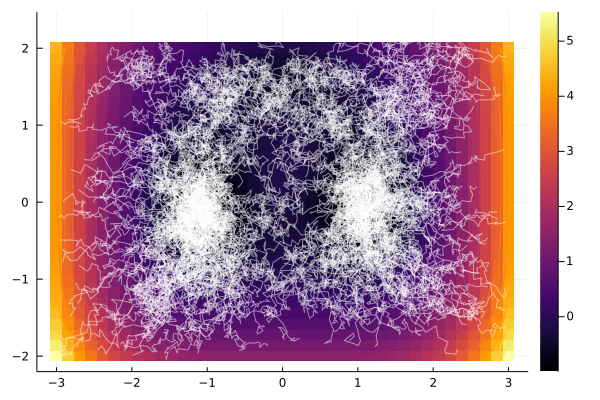

In [101]:
NN.plot(process.potential, process.box)
plot!(xt[1, :, 1:10:end], xt[2, :, 1:10:end], color="white", legend=false, alpha=0.5) |> display
savefig("isoTWdata.pdf")

# Learning $\chi$

In [97]:
# ISOKANN only needs start and end points, condense trajectories to this dense format
function foldbranches(x, branches)
    dim, steps, bs = size(x)
    samples = Int(bs / branches)
    reshape(x, dim, steps, branches, samples)
end

function condensetrajectories(x)
    dim, steps, branches, samples = size(x)
    xx = similar(x, dim, branches+1, samples)
    xx[:, 1, :] = x[:, 1, 1, :]
    xx[:, 2:end, :] = x[:, end, :, :]
    xx
end

trajs = condensetrajectories(foldbranches(xt, branches));

In [98]:
using IJulia
IJulia.clear_output(true)
i = 0
function cb(model, loss)
    if (i % 10) == 1
        p1 = plot(loss, yaxis=:log)
        p2 = NN.plot(model, process.box)
        IJulia.clear_output(true)
        p1 |> display
        p2 |> display
    end
    i+=1
end

Random.seed!(1)
model, loss = isokann(data=trajs, iter=10, poweriter=100, opt=ADAM(0.01), model=mlp([10,10]))#, cb=cb)


(Chain(Dense(2, 10, σ), Dense(10, 10, σ), Dense(10, 1), #2), [0.3185697433321668, 0.3185697433321668, 0.20513994492505833, 0.12479265527003636, 0.07650570644001424, 0.056728494026668595, 0.058412540422162436, 0.07139398524707306, 0.08528478071050706, 0.09307199810096345  …  0.0030620224078766675, 0.0030588588949036644, 0.0030557288752296936, 0.0030526082506025826, 0.003049485443423307, 0.0030463788203522225, 0.00304330259204848, 0.003040245295000485, 0.003037193594145543, 0.003034154554507737])

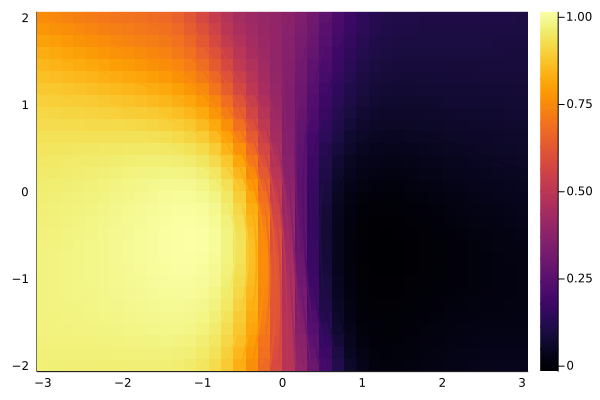

In [99]:
NN.plot(model, process.box)

# Residual of next iteration

In [102]:
NN.plot(model, process.box)
ys = trajs[:,2:end,:]
xs = trajs[:,1,:]
residual = koopmanexpectation(ys, model) - model(xs)
@show sqrt(mean(abs2, residual))
scatter!(xs[1,:], xs[2,:], markersize=abs.(residual)*40, legend=false)#, c=:balance, clims=(-0.2,.2))
savefig("isoTWres.pdf")

sqrt(mean(abs2, residual)) = 0.05516169365375232
